In [81]:
# Analysis of the data. 

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from pandas.plotting import register_matplotlib_converters

import pandas as pd
import os
import glob
import shutil
from pathlib import Path
from os import listdir
from os.path import isfile, join
import torch
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.utils.data import Dataset
import cv2

import torch_model #helper functions
import helper
from helper import export

# import albumentations as A
# from albumentations.pytorch import ToTensor

import random
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

import importlib

# Sagemaker
import boto3
import sagemaker
from sagemaker import get_execution_role

# Sound
from IPython.display import Audio
sound_file = 'Capture.mp3' # finish sound



In [4]:
!pip install cufflinks

    100% |████████████████████████████████| 81kB 10.0MB/s ta 0:00:01


  Running setup.py bdist_wheel for cufflinks ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/7d/ba/8d/38b672c3e40d8bd22dd60b8e6e29965b43f2b4be4d064e44d5
Successfully built cufflinks
fastai 1.0.60 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [82]:
# plotly standard imports
import plotly.graph_objs as go
# import chart_studio.plotly as py
import cufflinks
from plotly.offline import iplot
cufflinks.go_offline()
# Set global theme
cufflinks.set_config_file(world_readable=True, theme='white')

# Data processing and exploration
* The data comes with two summaries: one for the dataset and another for the metadata

In [2]:
# Import dataset summary and metadata.

dir_summary = Path("data")
fileName = 'Chest_xray_Corona_dataset_Summary.csv'
%time data_summary = pd.read_csv(dir_summary / fileName)
data_summary = data_summary.iloc[:,1:] # delete first column
print(fileName, ' imported')

fileName = 'Chest_xray_Corona_Metadata.csv'
%time metadata = pd.read_csv(dir_summary / fileName)
metadata = metadata.iloc[:,1:] # delete first column
metadata = metadata.fillna("")
print(fileName, ' imported')
metadata['folder'] = ""

# Indicate a folder to each image
for i in range(0,len(metadata)) :
    if metadata.iloc[i,3] != "":
        metadata.iloc[i,5] =  metadata.iloc[i,1] + "-" +  metadata.iloc[i,4] + "-" +  metadata.iloc[i,3]
    elif metadata.iloc[i,4] != "":
        metadata.iloc[i,5] =  metadata.iloc[i,1] + "-" +  metadata.iloc[i,4]
    else:
        metadata.iloc[i,5] =  metadata.iloc[i,1]

CPU times: user 9.57 ms, sys: 0 ns, total: 9.57 ms
Wall time: 15.8 ms
Chest_xray_Corona_dataset_Summary.csv  imported
CPU times: user 8.93 ms, sys: 3.77 ms, total: 12.7 ms
Wall time: 14.4 ms
Chest_xray_Corona_Metadata.csv  imported


In [3]:
print("Data summary:")
display(data_summary)
print("Metadata:")
display(metadata.head())

Data summary:


,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,NaN,NaN,1576
1,Pnemonia,Stress-Smoking,ARDS,2
2,Pnemonia,Virus,NaN,1493
3,Pnemonia,Virus,COVID-19,58
4,Pnemonia,Virus,SARS,4
5,Pnemonia,bacteria,NaN,2772
6,Pnemonia,bacteria,Streptococcus,5


Metadata:


,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,folder
0,IM-0128-0001.jpeg,Normal,TRAIN,,,Normal
1,IM-0127-0001.jpeg,Normal,TRAIN,,,Normal
2,IM-0125-0001.jpeg,Normal,TRAIN,,,Normal
3,IM-0122-0001.jpeg,Normal,TRAIN,,,Normal
4,IM-0119-0001.jpeg,Normal,TRAIN,,,Normal


In the local PC, a folder is created for each of the classes. This will be later uploaded to the S3 bucket with Cyberduck

In [ ]:
# Create folders to later use ImageFolder from torchvision. Only executed in local machine. 

os.makedirs("data/train/Normal", exist_ok=True)
os.makedirs("data/train/Pnemonia-bacteria", exist_ok=True)
os.makedirs("data/train/Pnemonia-Virus", exist_ok=True)
os.makedirs("data/train/Pnemonia-Virus-COVID-19", exist_ok=True)

Each picture is moved to a folder with the name of its class. The metadata table helps achieve this: 

In [ ]:
## First move images to train folder ##

# Get images names
src_folder = "data/Coronahack-Chest-XRay-Dataset/train"
dest_folder = "data/train" 
images = [f for f in listdir(src_folder) if isfile(join(src_folder, f))]
# Save each image in its corresponding class directory
counter = 0
for f in tqdm(images):
    if metadata.loc[metadata['X_ray_image_name'] == f].shape[0] > 0:
        class_folder = metadata.loc[metadata['X_ray_image_name'] == f, 'folder' ].to_list()[0]
        shutil.copy(os.path.join(src_folder, f), os.path.join(dest_folder, class_folder))
        counter += 1

print("archives: ", counter)

In [ ]:
## Second, move images to test folder ##

# Get images names
src_folder = "data/Coronahack-Chest-XRay-Dataset/test"
dest_folder = "data/test" 
images = [f for f in listdir(src_folder) if isfile(join(src_folder, f))]
# Save each image in its corresponding class directory
counter = 0
for f in tqdm(images):
    if metadata.loc[metadata['X_ray_image_name'] == f].shape[0] > 0:
        class_folder = metadata.loc[metadata['X_ray_image_name'] == f, 'folder' ].to_list()[0]
        shutil.copy(os.path.join(src_folder, f), os.path.join(dest_folder, class_folder))
        counter += 1

print("archives: ", counter)

In [14]:
# Compose transforms to explore the testing data. The training data is too large to store in the AWS notebook instance. 

batch_size = 10

editions = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                              
                              ])
test_data =  datasets.ImageFolder('data/test', transform=editions) # create the ImageFolder
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size) 

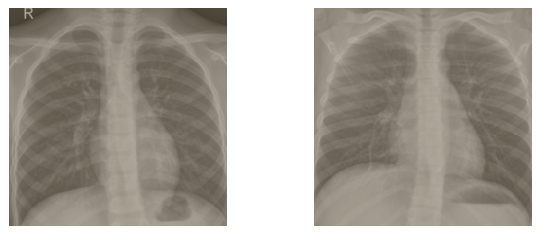

In [16]:
# change this to the trainloader or testloader 
data_iter = iter(test_loader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=2)
for ii in range(2):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax)

# Data augmentation

The data augmentation is carried out on the local pc with the albumentations package. https://albumentations-demo.herokuapp.com/ is an excelent website to see what each of the composes is doing.
Since there are only 58 images in the covid xrays, 8 are taken to the dataset, leaving 50 for training.

In [ ]:
doc_aug = A.Compose([
                    A.HorizontalFlip(p=0.5),
                    A.RandomGamma(gamma_limit=(20, 300), p=0.5),
                    A.Blur(always_apply=False, p=1.0, blur_limit=(3, 7)),
                    A.RandomBrightnessContrast(p=0.85),
                    A.Rotate(limit=4, p=0.9),
                    A.GaussNoise(p=0.25),
                    A.HueSaturationValue(p=0.5, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20))
                    ])

In [ ]:
# Augmentate training Pnemonia-Virus-COVID-19 images

src_folder = "data/train/Pnemonia-Virus-COVID-19"
DATASET_PATH = 'data/augmented'
IMAGES_PATH = f'{DATASET_PATH}/Pnemonia-Virus-COVID-19'
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)
images = [f for f in listdir(src_folder) if isfile(join(src_folder, f))] # get images names

for i in trange(50): # Augmentate 50 test images from covid. 
    xray = cv2.imread( os.path.join("data/train/Pnemonia-Virus-COVID-19", images[i]) )
    for k in range(25): # 25 augmentations per image will produce enough pictures to balance the training dataset. 
        augmented = doc_aug(image=xray)
        file_name = f'foto_aug_{i}_{k}.jpg'
        cv2.imwrite(f'{IMAGES_PATH}/{file_name}', augmented['image'])

In [ ]:
# Augmentate test Pnemonia-Virus-COVID-19 images

src_folder = "data/test/Pnemonia-Virus-COVID-19"
DATASET_PATH = 'data/augmented/test'
IMAGES_PATH = f'{DATASET_PATH}/Pnemonia-Virus-COVID-19'
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)
images = [f for f in listdir(src_folder) if isfile(join(src_folder, f))] # get images names

for i in trange(8): # Augmentate 8 test images from covid. 
    xray = cv2.imread( os.path.join(src_folder, images[i]) )
    for k in range(25): # 25 augmentations per image will produce enough pictures to balance the test dataset. 
        augmented = doc_aug(image=xray)
        file_name = f'foto_aug_{i}_{k}.jpg'
        cv2.imwrite(f'{IMAGES_PATH}/{file_name}', augmented['image'])

# CNN with transfer learning

After uploading the data to the S3 bucket and the test dataset to the notebook instance, the model convolutional neural network is created. 

In [6]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = 'sagemaker-us-east-1-737841296628'

# Path to training data
train_url = 's3://{}/{}/{}'.format(bucket, 'data', 'train')
# train_url = 's3://{}/{}'.format(bucket, 'Testing')
# Path to testing data
# test_url = 's3://{}/{}/{}'.format(bucket, 'data', 'test')
# test_url = 's3://{}/{}'.format(bucket, 'Testing')

# Output path
prefix_out = "xray_model_output"
output_path = 's3://{}/{}'.format(bucket, prefix_out)

In [71]:
# instantiate a pytorch estimator
from sagemaker.pytorch import PyTorch

model_name = 'CNN_lr_0001'
cnn_estimator = PyTorch(entry_point='train.py',
                    source_dir='CNN', 
                    role=role,
                    framework_version='1.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
#                         'n_inputs': ,  # input features. Will use default value. 
                        'epochs': 10, # could change to higher
                        'n_classes': 4, # output classifications
                        'freeze_all': 'True', # Freeze training for all "features" layers
                        'model_name': model_name,
                        'lr':0.001
                    })

In [ ]:
cnn_estimator.fit({'training': train_url})
Audio(sound_file, autoplay=True)

2020-06-23 22:30:04 Starting - Starting the training job...
2020-06-23 22:30:06 Starting - Launching requested ML instances............
2020-06-23 22:32:28 Starting - Preparing the instances for training.........
2020-06-23 22:33:43 Downloading - Downloading input data...............
2020-06-23 22:36:34 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-06-23 22:36:36,188 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-06-23 22:36:36,215 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-06-23 22:36:36,216 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-06-23 22:36:36,447 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-06-23 22:36:36,447 sagemaker-containers INFO     Generating setup.cfg


# try with smaller validation size

## Testing
We create a custom script to run the predictions, but use the data from the notebook instance instead of the S3 bucket. 

In [73]:
# It is important to know the uri from the trained model to later on deploy it. 
cnn_estimator.model_data

's3://sagemaker-us-east-1-737841296628/xray_model_output/sagemaker-pytorch-2020-06-23-22-30-03-882/output/model.tar.gz'

In [74]:
# uri from the CNN trained model
CNN_freeze_all_features = 's3://sagemaker-us-east-1-737841296628/xray_model_output/sagemaker-pytorch-2020-06-23-11-27-23-493/output/model.tar.gz'
CNN_unfreeze_all_features = 's3://sagemaker-us-east-1-737841296628/xray_model_output/sagemaker-pytorch-2020-06-23-14-26-25-447/output/model.tar.gz'
CNN_lr_01 = 's3://sagemaker-us-east-1-737841296628/xray_model_output/sagemaker-pytorch-2020-06-23-19-44-17-036/output/model.tar.gz'
CNN_lr_0001 = 's3://sagemaker-us-east-1-737841296628/xray_model_output/sagemaker-pytorch-2020-06-23-22-30-03-882/output/model.tar.gz'

In [75]:
# Extract the summary from the model output.
data_dir = 'model_data'
os.makedirs(data_dir, exist_ok=True)
summary = 'xray_model_output/{}/output/output.tar.gz'.format(cnn_estimator.latest_training_job.name)
sagemaker_session.download_data(path=data_dir, bucket=bucket, key_prefix=summary)
!tar --extract --file model_data/output.tar.gz -C model_data

In [76]:
stats_df = pd.read_csv(os.path.join(data_dir,model_name + "_summary.csv"))
stats_df = stats_df.drop(columns=['Unnamed: 0'])

In [79]:
stats_df

,epoch,train_loss,valid_loss
0,1,0.875308,0.648656
1,2,0.625243,0.551017
2,3,0.544941,0.480481
3,4,0.499844,0.456159
4,5,0.477628,0.435278
5,6,0.450930,0.413640
6,7,0.428965,0.405502
7,8,0.408036,0.395885
8,9,0.404858,0.384118
9,10,0.388412,0.369755


In [80]:
stats_df.iplot(
                mode='lines',
    #                                 kind = 'bar',
    #                                 barmode = 'stack',
                opacity=0.8,
                size=8,
                symbol=1,
                xTitle='Epoch',
                yTitle='Loss',
                x = 'epoch',
                xrange = [0,10],
#                 yrange = [0,16000],
                y = ['train_loss', 'valid_loss'],
#                 title='Test model'#,
    #                                 fill = True
                )

In [83]:
# importing PyTorchModel
from sagemaker.pytorch import PyTorchModel

# Create a model from the trained estimator data
# And point to the prediction script
cnn_model = PyTorchModel(model_data=CNN_lr_0001, # change this name when switching model!!
                     role = role,
                     framework_version='1.0',
                     entry_point='predict.py',
                     source_dir='CNN')

In [84]:
# Deploy model for predictions (about 8 min)
%time cnn_predictor = cnn_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge') # ml.p2.xlarge did not work

Audio(sound_file, autoplay=True) # Notify when finished

-----------------!CPU times: user 406 ms, sys: 29.1 ms, total: 435 ms
Wall time: 8min 33s


In [66]:
# os.makedirs("data/test/Normal", exist_ok=True)
# os.makedirs("data/test/Pnemonia-bacteria", exist_ok=True)
# os.makedirs("data/test/Pnemonia-bacteria-Streptococcus", exist_ok=True)
# os.makedirs("data/test/Pnemonia-Stress-Smoking-ARDS", exist_ok=True)
# os.makedirs("data/test/Pnemonia-Virus", exist_ok=True)
# os.makedirs("data/test/Pnemonia-Virus-COVID-19", exist_ok=True)


In [85]:
# Compose transforms

batch_size = 2 # if bigger, it causes trouble when reading the last batch. 

editions = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))   # new thing                            
                              ])
test_data =  datasets.ImageFolder('data/test', transform=editions) # create the ImageFolder
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size) 

In [136]:
# Explore format of the input images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

array([[[[-0.78039217, -0.77254903, -0.78039217, ..., -0.77254903,
          -0.77254903, -0.77254903],
         [-0.7882353 , -0.78039217, -0.78039217, ..., -0.77254903,
          -0.77254903, -0.77254903],
         [-0.7882353 , -0.7882353 , -0.7882353 , ..., -0.77254903,
          -0.77254903, -0.77254903],
         ...,
         [-0.40392154, -0.31764704, -0.2235294 , ...,  0.1686275 ,
           0.27843142,  0.3411765 ],
         [-0.42745095, -0.3333333 , -0.23137254, ...,  0.19215691,
           0.2313726 ,  0.32549024],
         [-0.44313723, -0.35686272, -0.24705881, ...,  0.20784318,
           0.19215691,  0.28627455]],

        [[-0.78039217, -0.77254903, -0.78039217, ..., -0.77254903,
          -0.77254903, -0.77254903],
         [-0.7882353 , -0.78039217, -0.78039217, ..., -0.77254903,
          -0.77254903, -0.77254903],
         [-0.7882353 , -0.7882353 , -0.7882353 , ..., -0.77254903,
          -0.77254903, -0.77254903],
         ...,
         [-0.40392154, -0.31764704

In [143]:
labels.data[3]

tensor(0)

In [125]:
# Explore output of predictor
output = cnn_predictor.predict(images)

# print(labels[1])

In [128]:
output

array([[ 2.6822252 ,  0.21832854, -2.8939404 ,  0.06830128],
       [ 3.5298753 ,  0.15273398, -3.3427687 ,  0.17726411],
       [ 5.187379  , -0.32000798, -4.661146  , -0.02821359],
       [-3.2633731 ,  2.358542  , -2.3593538 ,  3.3248444 ],
       [ 5.30944   , -0.2560891 , -4.195779  , -0.7937871 ],
       [ 5.0530868 ,  0.8841881 , -6.20458   ,  0.5221791 ],
       [ 3.262228  , -0.5997563 , -3.2529352 ,  0.67728084],
       [ 3.7789412 , -0.1315236 , -4.609997  ,  1.003515  ],
       [ 1.7277694 ,  1.4712102 , -5.041195  ,  1.8918152 ],
       [ 5.2805433 , -0.35680118, -4.6307335 , -0.28985697]],
      dtype=float32)

In [129]:
torch.from_numpy(output.astype('float32'))

tensor([[ 2.6822,  0.2183, -2.8939,  0.0683],
        [ 3.5299,  0.1527, -3.3428,  0.1773],
        [ 5.1874, -0.3200, -4.6611, -0.0282],
        [-3.2634,  2.3585, -2.3594,  3.3248],
        [ 5.3094, -0.2561, -4.1958, -0.7938],
        [ 5.0531,  0.8842, -6.2046,  0.5222],
        [ 3.2622, -0.5998, -3.2529,  0.6773],
        [ 3.7789, -0.1315, -4.6100,  1.0035],
        [ 1.7278,  1.4712, -5.0412,  1.8918],
        [ 5.2805, -0.3568, -4.6307, -0.2899]])

In [80]:
data_dir = 'data'
prefix = 'data/test/' # it does not want to accept a folder.

In [59]:
# Attempt to download images from S3
sagemaker_session.list_s3_files(bucket=bucket, key_prefix = prefix)

['data/test/',
 'data/test/Normal/',
 'data/test/Normal/IM-0001-0001.jpeg',
 'data/test/Normal/IM-0003-0001.jpeg',
 'data/test/Normal/IM-0005-0001.jpeg',
 'data/test/Normal/IM-0006-0001.jpeg',
 'data/test/Normal/IM-0007-0001.jpeg',
 'data/test/Normal/IM-0009-0001.jpeg',
 'data/test/Normal/IM-0010-0001.jpeg',
 'data/test/Normal/IM-0011-0001-0001.jpeg',
 'data/test/Normal/IM-0011-0001-0002.jpeg',
 'data/test/Normal/IM-0011-0001.jpeg',
 'data/test/Normal/IM-0013-0001.jpeg',
 'data/test/Normal/IM-0015-0001.jpeg',
 'data/test/Normal/IM-0016-0001.jpeg',
 'data/test/Normal/IM-0017-0001.jpeg',
 'data/test/Normal/IM-0019-0001.jpeg',
 'data/test/Normal/IM-0021-0001.jpeg',
 'data/test/Normal/IM-0022-0001.jpeg',
 'data/test/Normal/IM-0023-0001.jpeg',
 'data/test/Normal/IM-0025-0001.jpeg',
 'data/test/Normal/IM-0027-0001.jpeg',
 'data/test/Normal/IM-0028-0001.jpeg',
 'data/test/Normal/IM-0029-0001.jpeg',
 'data/test/Normal/IM-0030-0001.jpeg',
 'data/test/Normal/IM-0031-0001.jpeg',
 'data/test/Norma

In [76]:
sagemaker_session.download_data(path=data_dir, bucket=bucket, key_prefix=prefix) # it did not work, had to be done manually.

# try a different downloader for the test data in S3 bucket
downloader = sagemaker.s3.S3Downloader()
s3_uri = 's3://{}/{}'.format(bucket,prefix)
s3_uri
downloader.download(s3_uri, data_dir) # did not work either

TypeError: 'NoneType' object is not iterable

In [79]:
# After manually uploading the test data in a zip, extract it to the 'data' folder.
!unzip data/test.zip

Archive:  data/test.zip
   creating: test/
   creating: test/Normal/
  inflating: test/Normal/IM-0001-0001.jpeg  
  inflating: test/Normal/IM-0003-0001.jpeg  
  inflating: test/Normal/IM-0005-0001.jpeg  
  inflating: test/Normal/IM-0006-0001.jpeg  
  inflating: test/Normal/IM-0007-0001.jpeg  
  inflating: test/Normal/IM-0009-0001.jpeg  
  inflating: test/Normal/IM-0010-0001.jpeg  
  inflating: test/Normal/IM-0011-0001-0001.jpeg  
  inflating: test/Normal/IM-0011-0001-0002.jpeg  
  inflating: test/Normal/IM-0011-0001.jpeg  
  inflating: test/Normal/IM-0013-0001.jpeg  
  inflating: test/Normal/IM-0015-0001.jpeg  
  inflating: test/Normal/IM-0016-0001.jpeg  
  inflating: test/Normal/IM-0017-0001.jpeg  
  inflating: test/Normal/IM-0019-0001.jpeg  
  inflating: test/Normal/IM-0021-0001.jpeg  
  inflating: test/Normal/IM-0022-0001.jpeg  
  inflating: test/Normal/IM-0023-0001.jpeg  
  inflating: test/Normal/IM-0025-0001.jpeg  
  inflating: test/Normal/IM-0027-0001.jpeg  
  inflating: test/Nor

  inflating: test/Normal/NORMAL2-IM-0316-0001.jpeg  
  inflating: test/Normal/NORMAL2-IM-0317-0001.jpeg  
  inflating: test/Normal/NORMAL2-IM-0319-0001.jpeg  
  inflating: test/Normal/NORMAL2-IM-0321-0001.jpeg  
  inflating: test/Normal/NORMAL2-IM-0322-0001.jpeg  
  inflating: test/Normal/NORMAL2-IM-0323-0001.jpeg  
  inflating: test/Normal/NORMAL2-IM-0325-0001.jpeg  
  inflating: test/Normal/NORMAL2-IM-0326-0001.jpeg  
  inflating: test/Normal/NORMAL2-IM-0327-0001.jpeg  
  inflating: test/Normal/NORMAL2-IM-0328-0001.jpeg  
  inflating: test/Normal/NORMAL2-IM-0329-0001.jpeg  
  inflating: test/Normal/NORMAL2-IM-0330-0001.jpeg  
  inflating: test/Normal/NORMAL2-IM-0331-0001.jpeg  
  inflating: test/Normal/NORMAL2-IM-0332-0001.jpeg  
  inflating: test/Normal/NORMAL2-IM-0333-0001.jpeg  
  inflating: test/Normal/NORMAL2-IM-0335-0001.jpeg  
  inflating: test/Normal/NORMAL2-IM-0336-0001.jpeg  
  inflating: test/Normal/NORMAL2-IM-0337-0001.jpeg  
  inflating: test/Normal/NORMAL2-IM-0338-0001.

  inflating: test/Pnemonia-bacteria/person134_bacteria_643.jpeg  
  inflating: test/Pnemonia-bacteria/person134_bacteria_644.jpeg  
  inflating: test/Pnemonia-bacteria/person135_bacteria_646.jpeg  
  inflating: test/Pnemonia-bacteria/person135_bacteria_647.jpeg  
  inflating: test/Pnemonia-bacteria/person136_bacteria_648.jpeg  
  inflating: test/Pnemonia-bacteria/person136_bacteria_649.jpeg  
  inflating: test/Pnemonia-bacteria/person136_bacteria_650.jpeg  
  inflating: test/Pnemonia-bacteria/person136_bacteria_652.jpeg  
  inflating: test/Pnemonia-bacteria/person136_bacteria_654.jpeg  
  inflating: test/Pnemonia-bacteria/person137_bacteria_655.jpeg  
  inflating: test/Pnemonia-bacteria/person138_bacteria_657.jpeg  
  inflating: test/Pnemonia-bacteria/person138_bacteria_658.jpeg  
  inflating: test/Pnemonia-bacteria/person138_bacteria_659.jpeg  
  inflating: test/Pnemonia-bacteria/person139_bacteria_661.jpeg  
  inflating: test/Pnemonia-bacteria/person139_bacteria_662.jpeg  
  inflatin

  inflating: test/Pnemonia-Virus/person14_virus_44.jpeg  
  inflating: test/Pnemonia-Virus/person15_virus_46.jpeg  
  inflating: test/Pnemonia-Virus/person1608_virus_2786.jpeg  
  inflating: test/Pnemonia-Virus/person1610_virus_2793.jpeg  
  inflating: test/Pnemonia-Virus/person1612_virus_2797.jpeg  
  inflating: test/Pnemonia-Virus/person1612_virus_2798.jpeg  
  inflating: test/Pnemonia-Virus/person1613_virus_2799.jpeg  
  inflating: test/Pnemonia-Virus/person1614_virus_2800.jpeg  
  inflating: test/Pnemonia-Virus/person1615_virus_2801.jpeg  
  inflating: test/Pnemonia-Virus/person1616_virus_2802.jpeg  
  inflating: test/Pnemonia-Virus/person1618_virus_2805.jpeg  
  inflating: test/Pnemonia-Virus/person1619_virus_2806.jpeg  
  inflating: test/Pnemonia-Virus/person1620_virus_2807.jpeg  
  inflating: test/Pnemonia-Virus/person1622_virus_2810.jpeg  
  inflating: test/Pnemonia-Virus/person1623_virus_2813.jpeg  
  inflating: test/Pnemonia-Virus/person1625_virus_2817.jpeg  
  inflating: tes

### Calculate performance

In [86]:
# test over 4 x-ray classes
classes = test_loader.dataset.classes
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))


# iterate over test data
for data, target in tqdm(test_loader):

    # forward pass: compute predicted outputs by passing inputs to the model
    output = cnn_predictor.predict(data)

    
    # convert output probabilities to predicted class
    output = torch.from_numpy(output.astype('float32'))
    _, pred = torch.max(output, 1) 
    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) 

    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

for i in range(4):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Audio(sound_file, autoplay=True)

100%|██████████| 416/416 [04:48<00:00,  1.44it/s]

Test Accuracy of Normal: 54% (128/234)
Test Accuracy of Pnemonia-Virus: 83% (123/148)
Test Accuracy of Pnemonia-Virus-COVID-19: 73% (153/208)
Test Accuracy of Pnemonia-bacteria: 86% (210/242)

Test Accuracy (Overall): 73% (614/832)


In [87]:
def delete_endpoint(predictor):
    try:
        boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
        print('Deleted {}'.format(predictor.endpoint))
    except:
        print('Already deleted: {}'.format(predictor.endpoint))

In [88]:
# Delete the predictor endpoint 
delete_endpoint(cnn_predictor)

Deleted sagemaker-pytorch-2020-06-24-01-21-33-652


In [6]:
!zip -rvu capstone.zip Data_analysis

  adding: model_data/	(in=0) (out=0) (stored 0%)
  adding: model_data/output.tar.gz	(in=394) (out=394) (stored 0%)
  adding: model_data/CNN_unfreeze_features_summary.csv	(in=458) (out=255) (deflated 44%)
  adding: model_data/model_test_1_summary.csv	(in=68) (out=66) (deflated 3%)
  adding: model_data/CNN_lr_0001_summary.csv	(in=455) (out=255) (deflated 44%)
  adding: model_data/.ipynb_checkpoints/	(in=0) (out=0) (stored 0%)
  adding: model_data/CNN_freeze_all_features_summary.csv	(in=459) (out=255) (deflated 44%)
  adding: model_data/CNN_lr_0.1_summary.csv	(in=454) (out=254) (deflated 44%)
total bytes=16029, compressed=5890 -> 63% savings
